In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import math
from collections import Counter
from datetime import timedelta
from google.colab import files  # Importation du module pour permettre le téléchargement de fichiers depuis Colab

# --- Fonctions Utilitaires ---

def compute_entropy(lst):
    """
    Calcule l'entropie de Shannon d'une liste de valeurs.
    L'entropie mesure le degré d'incertitude dans la distribution des valeurs.
    Si la liste est vide, la fonction retourne 0.
    """
    counts = Counter(lst)             # Compte le nombre d'occurrences de chaque élément dans la liste
    total = sum(counts.values())      # Calcule le nombre total d'éléments
    if total == 0:
        return 0                      # Retourne 0 si la liste est vide
    # Calcule l'entropie selon la formule -∑(p * log2(p)) pour chaque valeur
    return -sum((count / total) * math.log2(count / total) for count in counts.values())

def get_flow_label(label_str):
    """
    Retourne 1 si 'From-Botnet' apparaît dans le label, sinon 0.
    Cette fonction permet d'identifier si le flow est malicieux.
    """
    return 1 if "From-Botnet" in str(label_str) else 0

def parse_state_flags(state_str):
    """
    Extrait les flags TCP (SYN, ACK, FIN, RST, PSH, URG) à partir du champ 'State'.
    La fonction s'assure d'abord que la valeur est une chaîne, puis retourne un tuple
    indiquant pour chaque flag s'il est présent (1) ou absent (0).
    """
    state_str = str(state_str)  # Convertir en chaîne au cas où ce ne serait pas déjà le cas
    return (
        1 if 'S' in state_str else 0,  # Vérifie la présence de 'S' pour SYN
        1 if 'A' in state_str else 0,  # Vérifie la présence de 'A' pour ACK
        1 if 'F' in state_str else 0,  # Vérifie la présence de 'F' pour FIN
        1 if 'R' in state_str else 0,  # Vérifie la présence de 'R' pour RST
        1 if 'P' in state_str else 0,  # Vérifie la présence de 'P' pour PSH
        1 if 'U' in state_str else 0   # Vérifie la présence de 'U' pour URG
    )

def add_flag_columns(df):
    """
    Ajoute les colonnes de flags TCP au DataFrame.
    Pour chaque ligne, la fonction 'parse_state_flags' est appliquée sur la colonne 'State'
    pour créer de nouvelles colonnes ('syn', 'ack', 'fin', 'rst', 'psh', 'urg').
    """
    # On applique 'parse_state_flags' à chaque valeur de la colonne 'State'
    flags_df = df["State"].apply(lambda x: pd.Series(parse_state_flags(x),
                                                      index=["syn", "ack", "fin", "rst", "psh", "urg"]))
    # On concatène les colonnes de flags obtenues avec le DataFrame d'origine
    return pd.concat([df, flags_df], axis=1)

def aggregate_features(df, malicious_threshold=0.0):
    """
    Agrège les caractéristiques par adresse IP source.
    Pour chaque IP, la fonction calcule :
      - Les fréquences des différents flags TCP en divisant la somme des occurrences de chaque flag
        par le nombre total de flows.
      - Les entropies des listes de ports source, ports destination, adresses destination et du champ 'State'.
      - Un label agrégé (AggregatedLabel) qui vaut 1 si le ratio de flows malicieux dépasse le seuil
        (défini par malicious_threshold), sinon 0.
    Retourne un DataFrame où chaque ligne correspond aux caractéristiques agrégées pour une IP.
    """
    aggregated_rows = []
    # Regrouper le DataFrame par adresse IP source (colonne "SrcAddr")
    for ip, group in df.groupby("SrcAddr"):
        total_flows = len(group)
        if total_flows == 0:
            continue

        # Calcul des fréquences des flags TCP pour cette IP
        syn_freq = group["syn"].sum() / total_flows
        ack_freq = group["ack"].sum() / total_flows
        fin_freq = group["fin"].sum() / total_flows
        rst_freq = group["rst"].sum() / total_flows
        psh_freq = group["psh"].sum() / total_flows
        urg_freq = group["urg"].sum() / total_flows

        # Calcul des entropies pour d'autres caractéristiques à partir des listes
        src_port_entropy  = compute_entropy(group["Sport"].tolist())
        dest_port_entropy = compute_entropy(group["Dport"].tolist())
        dest_ip_entropy   = compute_entropy(group["DstAddr"].tolist())
        flag_entropy      = compute_entropy(group["State"].tolist())

        # Calcul du label agrégé pour l'IP : on considère que l'IP est malicieuse (label=1)
        # si le ratio de flows malicieux (déterminé par get_flow_label) dépasse le seuil.
        labels_list = group["Label"].tolist()
        infected_count = sum(get_flow_label(lbl) for lbl in labels_list)
        ratio_infected = infected_count / total_flows
        aggregated_label = 1 if ratio_infected > malicious_threshold else 0

        # Construction d'un dictionnaire avec toutes les caractéristiques calculées pour cette IP
        aggregated_rows.append({
            "SrcIP": ip,
            "TotalFlows": total_flows,
            "SynFreq": syn_freq,
            "AckFreq": ack_freq,
            "FinFreq": fin_freq,
            "RstFreq": rst_freq,
            "PshFreq": psh_freq,
            "UrgFreq": urg_freq,
            "SrcPortEntropy": src_port_entropy,
            "DestPortEntropy": dest_port_entropy,
            "DestIPEntropy": dest_ip_entropy,
            "FlagEntropy": flag_entropy,
            "AggregatedLabel": aggregated_label
        })
    # Retourne un DataFrame construit à partir de la liste des dictionnaires
    return pd.DataFrame(aggregated_rows)

# Définir le scénario d'entraînement à utiliser (ici, scénario 12) et le chemin d'accès aux fichiers
scenario_id = 12
base_path = "/content/drive/MyDrive/Training scenarios/"

# Construire le nom du fichier correspondant au scénario
file_name = f"{base_path}scenario{scenario_id}.binetflow"
print(f"\nLecture du scénario {scenario_id} depuis {file_name} ...")

# Charger le fichier .binetflow complet pour ce scénario
df_all = pd.read_csv(file_name, delimiter=",", low_memory=False)

# Ajouter une colonne pour identifier le scénario (utile pour le suivi)


# Afficher la forme du DataFrame combiné d'entraînement
print("\n=== Forme du dataset combiné d'entraînement:", df_all.shape, "===")
# Filtrer le DataFrame pour ne conserver que les flows TCP
df_all["Proto"] = df_all["Proto"].str.lower()
df_tcp = df_all[df_all["Proto"] == "tcp"].copy()
print("Nombre de flows TCP dans le dataset d'entraînement:", df_tcp.shape[0])

# Appliquer le parsing vectorisé pour extraire les flags TCP et ajouter les colonnes correspondantes
df_tcp = add_flag_columns(df_tcp)

# Agréger les caractéristiques par adresse IP source (calcul des fréquences, entropies, et label agrégé)
df_features = aggregate_features(df_tcp, malicious_threshold=0.0)
print("\nForme du dataset agrégé d'entraînement (par adresses IP):", df_features.shape)
print(df_features.head(10))

# Sauvegarder le DataFrame agrégé d'entraînement sur Google Drive et le télécharger localement
output_csv_drive_path = f"{base_path}training_features_with_labels.csv"
df_features.to_csv(output_csv_drive_path, index=False)
print(f"\n✅ Dataset d'entraînement sauvegardé sur Drive: {output_csv_drive_path}")

local_train_filename = "training_features_with_labels.csv"
df_features.to_csv(local_train_filename, index=False)
files.download(local_train_filename)
print("\n✅ Dataset d'entraînement téléchargé localement.")



Lecture du scénario 12 depuis /content/drive/MyDrive/Training scenarios/scenario12.binetflow ...

=== Forme du dataset combiné d'entraînement: (325471, 15) ===
Nombre de flows TCP dans le dataset d'entraînement: 70724

Forme du dataset agrégé d'entraînement (par adresses IP): (4510, 13)
          SrcIP  TotalFlows  SynFreq  AckFreq   FinFreq   RstFreq  PshFreq  \
0  1.152.38.108           4      1.0      1.0  1.000000  0.000000      0.0   
1  1.171.111.28           2      1.0      0.0  0.000000  0.000000      0.0   
2    1.186.32.6           1      1.0      1.0  1.000000  0.000000      1.0   
3  1.195.128.90           2      1.0      1.0  0.500000  1.000000      1.0   
4   1.39.43.179           2      1.0      1.0  0.500000  0.500000      1.0   
5   1.52.99.196           1      1.0      0.0  0.000000  1.000000      0.0   
6  1.57.118.154           1      1.0      1.0  1.000000  1.000000      1.0   
7    1.66.96.27           1      1.0      1.0  1.000000  0.000000      1.0   
8    1.82

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Dataset d'entraînement téléchargé localement.


Shape de la matrice de données : (4510, 4)
Shape des composantes principales : (4, 4)
Valeurs propres : [2.34877198 0.70202731 0.55801537 0.39207246]
Ratio d'explication des variances : [0.5870628  0.17546791 0.13947291 0.09799638]


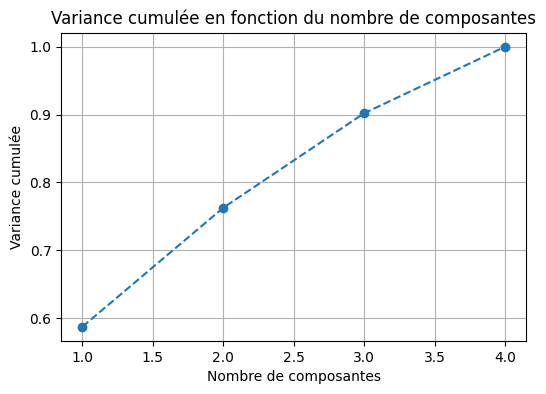

Shape des composantes significatives : (4, 4)
Valeurs propres significatives : [2.34877198 0.70202731 0.55801537 0.39207246]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca(df, feature_cols, eigen_threshold=1e-6, plot_variance=True):
    """
    Effectue une Analyse en Composantes Principales (PCA) sur un DataFrame
    en se basant sur les colonnes spécifiées (par exemple, les mesures d'entropie issues de l'agrégation).

    Paramètres :
      - df : DataFrame contenant les données d'entraînement agrégées (par IP ou par fenêtre temporelle).
      - feature_cols : Liste des colonnes de caractéristiques à utiliser pour le PCA.
                       Par exemple, ['SrcPortEntropy', 'DestPortEntropy', 'DestIPEntropy', 'FlagEntropy'].
      - eigen_threshold : Seuil minimal pour retenir une composante ;
                          on ignore les composantes dont la variance (valeur propre) est inférieure à ce seuil.
      - plot_variance : Booléen indiquant si l'on souhaite afficher la courbe de variance cumulée,
                        afin de visualiser le nombre de composantes nécessaires pour capturer la majorité de la variance.

    Retourne :
      - data_pca : Les données transformées dans l'espace des composantes principales.
      - pca : L'objet PCA ajusté (contenant notamment les vecteurs propres et les valeurs propres).
      - significant_components : Matrice des composantes significatives (celles dont la variance dépasse le seuil eigen_threshold).
      - eigenvalues_sig : Les valeurs propres associées aux composantes retenues.
      - data_scaled : La matrice des données standardisées utilisée pour le PCA.
    """
    # 1. Construction de la matrice de données à partir des colonnes sélectionnées.
    # Ici, on extrait uniquement les colonnes définies dans feature_cols.
    data_matrix = df[feature_cols].values
    print(f"Shape de la matrice de données : {data_matrix.shape}")

    # 2. Standardisation des données :
    # Cette étape met toutes les caractéristiques sur la même échelle (moyenne = 0, écart-type = 1)
    # afin d'éviter que certaines variables à grande échelle dominent l'analyse.
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_matrix)

    # 3. Application du PCA sur la matrice standardisée :
    # On ne fixe pas le nombre de composantes pour capturer l'intégralité de la variance.
    pca = PCA(n_components=None, svd_solver='full')
    data_pca = pca.fit_transform(data_scaled)

    # 4. Récupération des résultats du PCA :
    # - principal_components : les vecteurs propres qui définissent le nouvel espace.
    # - eigenvalues : la variance expliquée par chaque composante.
    # - explained_variance_ratio : la part de la variance totale expliquée par chaque composante.
    principal_components = pca.components_
    eigenvalues = pca.explained_variance_
    explained_variance_ratio = pca.explained_variance_ratio_

    print(f"Shape des composantes principales : {principal_components.shape}")
    print("Valeurs propres :", eigenvalues)
    print("Ratio d'explication des variances :", explained_variance_ratio)

    # 5. Optionnel : Affichage de la courbe de variance cumulée
    # Cela permet de visualiser combien de composantes sont nécessaires pour expliquer une partie significative
    # de la variance totale des données.
    if plot_variance:
        cumulative_variance = np.cumsum(explained_variance_ratio)
        plt.figure(figsize=(6,4))
        plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
        plt.xlabel('Nombre de composantes')
        plt.ylabel('Variance cumulée')
        plt.title('Variance cumulée en fonction du nombre de composantes')
        plt.grid(True)
        plt.show()

    # 6. Sélection des composantes significatives :
    # On ne retient que les composantes dont la variance (valeur propre) est supérieure au seuil défini (eigen_threshold)
    significant_mask = eigenvalues > eigen_threshold
    significant_components = principal_components[significant_mask]
    eigenvalues_sig = eigenvalues[significant_mask]

    print(f"Shape des composantes significatives : {significant_components.shape}")
    print("Valeurs propres significatives :", eigenvalues_sig)

    # 7. Retourner les résultats du PCA ainsi que les données standardisées
    return data_pca, pca, significant_components, eigenvalues_sig, data_scaled


# ============================================================
# APPLICATION DU PCA SUR LES DONNÉES D'ENTRAÎNEMENT (df_train_features)
# ============================================================
# Nous utilisons ici les mesures d'entropie issues de l'agrégation par adresse IP
# comme caractéristiques pour le PCA.
features = ['SrcPortEntropy', 'DestPortEntropy', 'DestIPEntropy', 'FlagEntropy']

# La fonction perform_pca est appliquée sur le DataFrame df_train_features,
# qui contient pour chaque IP les caractéristiques extraites (dont les entropies)
# ainsi qu'un label agrégé (AggregatedLabel).
data_pca, pca_model, significant_components, eigenvalues_sig, data_scaled = perform_pca(
    df_features,
    features,
    eigen_threshold=1e-6,
    plot_variance=True
)


In [ ]:
import numpy as np

def calculate_anomaly_scores(k, data_matrix, significant_components, eigenvalues):
    """
    Calcule les scores d'anomalie en projetant les données standardisées sur deux sous-espaces :
      - L'espace majeur : constitué des composantes principales dominantes (avec forte variance).
      - L'espace mineur : constitué des composantes restantes (avec faible variance).

    Ces scores permettent d'identifier les observations (par exemple, une IP agrégée) qui s'écartent fortement
    de la distribution normale, et donc potentiellement d'identifier des anomalies.

    Paramètres :
      - k (int) : Nombre de composantes considérées comme "mineures".
                  Par exemple, si k = 1, on considère la dernière composante comme l'espace mineur.
      - data_matrix (ndarray) : Matrice des données standardisées, obtenue après PCA.
                                Chaque ligne représente une observation.
      - significant_components (ndarray) : Matrice des composantes principales significatives,
                                           c'est-à-dire celles dont la variance (valeur propre)
                                           dépasse un seuil défini.
      - eigenvalues (ndarray) : Valeurs propres associées aux composantes significatives.

    Retourne :
      - anomaly_scores_major (ndarray) : Scores d'anomalie calculés dans l'espace majeur.
      - anomaly_scores_minor (ndarray) : Scores d'anomalie calculés dans l'espace mineur.
    """
    # Récupérer le nombre total de composantes significatives
    n_components = significant_components.shape[0]

    # Vérifier que k est inférieur au nombre total de composantes significatives,
    # sinon il n'est pas possible de définir un espace mineur distinct.
    if k >= n_components:
        raise ValueError("k must be less than the number of significant components")

    # Séparer les composantes en deux sous-espaces :
    # - L'espace majeur regroupe les premières (n_components - k) composantes, qui expliquent la majeure partie de la variance.
    major_components = significant_components[:n_components - k, :]  # Dimensions : ((n_components - k) x n_features)

    # - L'espace mineur regroupe les k dernières composantes, susceptibles de contenir des informations sur des anomalies.
    minor_components = significant_components[n_components - k:, :]  # Dimensions : (k x n_features)

    # Projection des données standardisées sur l'espace majeur.
    # Chaque observation est ainsi représentée dans le nouvel espace réduit constitué des composantes majeures.
    projected_major = data_matrix.dot(major_components.T)  # Dimensions : (n_samples x (n_components - k))

    # Projection des données standardisées sur l'espace mineur.
    projected_minor = data_matrix.dot(minor_components.T)  # Dimensions : (n_samples x k)

    # Extraction des valeurs propres associées aux sous-espaces :
    # - eigen_major correspond aux valeurs propres des composantes majeures.
    eigen_major = eigenvalues[:n_components - k]
    # - eigen_minor correspond aux valeurs propres des composantes mineures.
    eigen_minor = eigenvalues[n_components - k:]

    # Calcul des scores d'anomalie dans chaque sous-espace :
    # Pour chaque observation, on calcule la somme sur les composantes de (projection^2 / (eigenvalue^2)).
    # Cette formule normalise la contribution de chaque composante par sa variance.
    anomaly_scores_major = np.sum((projected_major ** 2) / np.square(eigen_major), axis=1)
    anomaly_scores_minor = np.sum((projected_minor ** 2) / np.square(eigen_minor), axis=1)

    # Un score d'anomalie élevé indique que l'observation s'écarte fortement du comportement normal
    # dans l'un des deux sous-espaces.
    return anomaly_scores_major, anomaly_scores_minor

# Choix de k (ici, on prend k = 1, ce qui signifie que la dernière composante est considérée comme l'espace mineur)
k = 1

# Calcul des scores d'anomalie en utilisant :
# - data_scaled : la matrice standardisée obtenue lors du PCA,
# - significant_components : les composantes principales significatives,
# - eigenvalues_sig : les valeurs propres associées à ces composantes.
anomaly_scores_major, anomaly_scores_minor = calculate_anomaly_scores(
    k,
    data_scaled,            # Matrice standardisée issue du PCA
    significant_components, # Composantes principales significatives
    eigenvalues_sig         # Valeurs propres correspondantes
)

# Affichage des scores d'anomalie pour chaque observation (chaque ligne correspond à une IP agrégée)
print("Scores d'anomalie (espace majeur) :", anomaly_scores_major)
print("Scores d'anomalie (espace mineur) :", anomaly_scores_minor)


Scores d'anomalie (espace majeur) : [0.82842102 0.41133583 0.23023828 ... 0.23023828 0.23023828 0.23023828]
Scores d'anomalie (espace mineur) : [9.2339677  0.3740145  0.22939944 ... 0.22939944 0.22939944 0.22939944]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def predict_anomalies(anomaly_scores_major, anomaly_scores_minor, threshold_major, threshold_minor):
    """
    Prédit si une observation (ici, une IP agrégée) est anormale en se basant sur
    les scores d'anomalie calculés dans deux sous-espaces : l'espace majeur et l'espace mineur.

    Une observation est considérée comme anormale (1) si au moins l'un des scores dépasse son seuil correspondant.

    Paramètres :
      - anomaly_scores_major (ndarray) : Scores d'anomalie obtenus en projetant les données sur l'espace majeur,
                                         c'est-à-dire sur les composantes principales avec forte variance.
      - anomaly_scores_minor (ndarray) : Scores d'anomalie obtenus en projetant les données sur l'espace mineur,
                                         c'est-à-dire sur les composantes principales avec faible variance.
      - threshold_major (float) : Seuil de détection pour l'espace majeur. Si le score dans cet espace est supérieur
                                  à ce seuil, cela peut indiquer un comportement atypique.
      - threshold_minor (float) : Seuil de détection pour l'espace mineur. Si le score dans cet espace est supérieur
                                  à ce seuil, cela peut également signaler une anomalie.

    Retourne :
      - predictions (ndarray) : Vecteur contenant la prédiction pour chaque observation
                                (1 si anormale, 0 sinon).
    """
    # Vérifie que les deux vecteurs de scores ont la même taille.
    # Cela garantit que pour chaque observation, nous avons un score dans chaque espace (majeur et mineur).
    if anomaly_scores_major.shape != anomaly_scores_minor.shape:
        raise ValueError("Les dimensions des scores d'anomalie (majeur et mineur) doivent être identiques.")

    # Pour chaque observation, nous utilisons une opération "logical_or" :
    # Si le score dans l'espace majeur dépasse le seuil 'threshold_major'
    # ou si le score dans l'espace mineur dépasse le seuil 'threshold_minor',
    # alors l'observation est considérée comme anormale.
    predictions = np.logical_or(anomaly_scores_major > threshold_major, anomaly_scores_minor > threshold_minor)

    # Conversion du résultat booléen (True/False) en entier (1/0) pour faciliter l'évaluation.
    return predictions.astype(int)

# Définition des seuils pour la détection d'anomalies.
# Ces valeurs peuvent être ajustées via validation croisée ou selon l'expertise de l'utilisateur.
threshold_major = 185.1  # Seuil pour le score d'anomalie dans l'espace majeur.
threshold_minor = 50     # Seuil pour le score d'anomalie dans l'espace mineur.

# IMPORTANT :
# - 'data_scaled' correspond à la matrice standardisée obtenue lors de l'application du PCA.
# - 'anomaly_scores_major' et 'anomaly_scores_minor' ont été calculés dans l'étape 7 en projetant
#   les données sur les sous-espaces majeur et mineur respectivement.
# Ainsi, ces vecteurs de scores ont une dimension égale au nombre d'observations (par exemple, IP agrégées).

# Calcul des prédictions : une IP sera considérée comme anormale si l'un de ses scores dépasse son seuil correspondant.
predictions = predict_anomalies(anomaly_scores_major, anomaly_scores_minor, threshold_major, threshold_minor)

# Ajout des prédictions dans le DataFrame d'entraînement agrégé.
# Le DataFrame df_train_features contient une ligne par adresse IP agrégée, avec ses caractéristiques et son label réel (AggregatedLabel).
df_features['Prediction'] = predictions

# Affichage des résultats pour vérification :
# On affiche les colonnes "SrcIP" (l'adresse IP), "AggregatedLabel" (le label réel) et "Prediction" (la prédiction obtenue).
print(df_features[['SrcIP', 'AggregatedLabel', 'Prediction']])


               SrcIP  AggregatedLabel  Prediction
0       1.152.38.108                0           0
1       1.171.111.28                0           0
2         1.186.32.6                0           0
3       1.195.128.90                0           0
4        1.39.43.179                0           0
...              ...              ...         ...
4505  99.226.242.133                0           0
4506  99.228.120.143                0           0
4507   99.230.193.68                0           0
4508  99.237.214.223                0           0
4509  99.238.100.150                0           0

[4510 rows x 3 columns]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ============================================================
# ÉTAPE 9 : CALCUL DES MÉTRIQUES DE PERFORMANCE
# (On suppose que 'AggregatedLabel' contient les vrais labels (la vérité terrain)
#  et 'Prediction' les prédictions obtenues à l'étape 8.)
# ============================================================

# Extraction des étiquettes réelles (true labels) et des prédictions (predicted labels)
# Le DataFrame df_train_features contient une ligne par adresse IP agrégée avec :
# - ses caractéristiques extraites,
# - le label agrégé (AggregatedLabel) indiquant si l'IP est malicieuse (1) ou normale (0),
# - et la prédiction obtenue par notre système de détection.
true_labels = df_features['AggregatedLabel']
predicted_labels = df_features['Prediction']

# Calcul de la matrice de confusion.
# La matrice de confusion compare les prédictions aux valeurs réelles et fournit :
# - TP (True Positives) : Nombre d'IP malicieuses correctement détectées (AggregatedLabel=1 et Prediction=1).
# - TN (True Negatives) : Nombre d'IP normales correctement identifiées (AggregatedLabel=0 et Prediction=0).
# - FP (False Positives) : Nombre d'IP normales faussement détectées comme malicieuses (AggregatedLabel=0 mais Prediction=1).
# - FN (False Negatives) : Nombre d'IP malicieuses non détectées (AggregatedLabel=1 mais Prediction=0).
TN, FP, FN, TP = confusion_matrix(true_labels, predicted_labels).ravel()

# Affichage des valeurs de la matrice de confusion.
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

# Calcul des métriques classiques à partir des valeurs de la matrice de confusion.

# FPR (False Positive Rate) : Taux de faux positifs, c'est-à-dire la proportion d'IP normales faussement détectées parmi toutes les IP normales.
FPR = FP / (TN + FP) if (TN + FP) > 0 else 0

# TPR (True Positive Rate) ou Recall : Taux de vrais positifs, c'est-à-dire la proportion d'IP malicieuses correctement détectées parmi toutes les IP malicieuses.
TPR = TP / (TP + FN) if (TP + FN) > 0 else 0

# Précision (Precision) : Proportion des IP détectées comme malicieuses qui sont effectivement malicieuses.
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Exactitude (Accuracy) : Proportion globale d'IP correctement classées (les IP normales et malicieuses).
accuracy = accuracy_score(true_labels, predicted_labels)

# F-measure (F1-score) : Mesure harmonique qui combine précision et recall pour évaluer l'efficacité globale du classifieur.
f_measure = 2 * precision * TPR / (precision + TPR) if (precision + TPR) > 0 else 0

# Affichage des métriques calculées avec un format arrondi à 4 décimales.
print(f"FPR: {FPR:.4f}")
print(f"TPR (Recall): {TPR:.4f}")
print(f"Précision: {precision:.4f}")
print(f"Exactitude (Accuracy): {accuracy:.4f}")
print(f"F-measure: {f_measure:.4f}")

# Affichage d'un rapport complet de classification qui détaille pour chaque classe (Normal et Malicieux) :
# - La précision, le rappel, le F1-score et le support (nombre d'exemples de chaque classe)
report = classification_report(true_labels, predicted_labels, target_names=["Normal", "Malicieux"])
print("\nClassification Report:\n", report)


TP: 3, TN: 4493, FP: 14, FN: 0
FPR: 0.0031
TPR (Recall): 1.0000
Précision: 0.1765
Exactitude (Accuracy): 0.9969
F-measure: 0.3000

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4507
   Malicieux       0.18      1.00      0.30         3

    accuracy                           1.00      4510
   macro avg       0.59      1.00      0.65      4510
weighted avg       1.00      1.00      1.00      4510



# Debugging

Itération sur différents seuils :



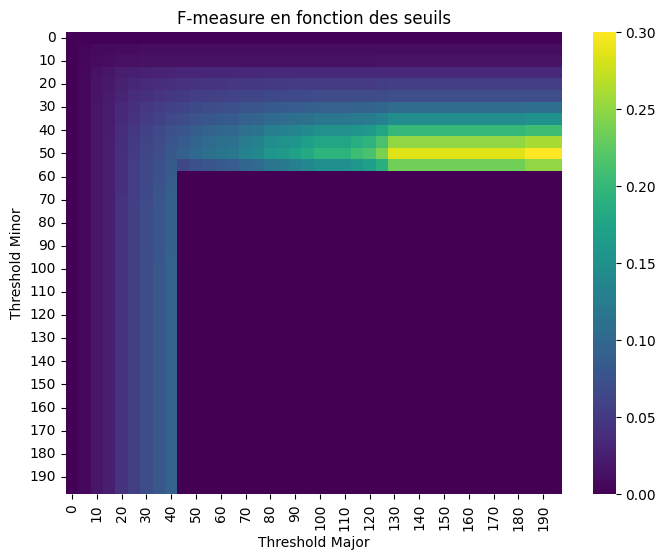

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def predict_anomalies(anomaly_scores_major, anomaly_scores_minor, threshold_major, threshold_minor):
    """
    Prédit si une observation est anormale en se basant sur les scores d'anomalie obtenus
    dans l'espace majeur et l'espace mineur.

    Une observation (par exemple, une IP agrégée) est considérée comme anormale (1)
    si l'un des scores dépasse le seuil correspondant.

    Paramètres :
      - anomaly_scores_major (ndarray) : Vecteur de scores d'anomalie dans l'espace majeur.
      - anomaly_scores_minor (ndarray) : Vecteur de scores d'anomalie dans l'espace mineur.
      - threshold_major (float) : Seuil de détection pour l'espace majeur.
      - threshold_minor (float) : Seuil de détection pour l'espace mineur.

    Retourne :
      - predictions (ndarray) : Vecteur binaire (0 ou 1) indiquant pour chaque observation
                                 si elle est considérée comme anormale.
    """
    # Vérifier que les deux vecteurs de scores ont exactement la même dimension
    if anomaly_scores_major.shape != anomaly_scores_minor.shape:
        raise ValueError("Les dimensions des scores d'anomalie (majeur et mineur) doivent être identiques.")

    # On considère une observation comme anormale si EITHER le score dans l'espace majeur
    # dépasse threshold_major ou le score dans l'espace mineur dépasse threshold_minor.
    predictions = np.logical_or(anomaly_scores_major > threshold_major, anomaly_scores_minor > threshold_minor)

    # On convertit le résultat booléen en entier (1 = anormal, 0 = normal) et on le retourne.
    return predictions.astype(int)

# Définition des intervalles de seuils à tester :
# Ici, on génère des seuils allant de 0 à 200 avec un pas de 5 pour l'espace majeur et mineur.
threshold_major_values = np.arange(0, 200, 5)
threshold_minor_values = np.arange(0, 200, 5)

results = []  # Cette liste servira à stocker les métriques pour chaque couple de seuils

print("Itération sur différents seuils :\n")
# Boucle sur chaque combinaison possible des seuils pour l'espace majeur et l'espace mineur
for t_major in threshold_major_values:
    for t_minor in threshold_minor_values:
        # Calculer les prédictions pour la combinaison de seuils actuelle
        preds = predict_anomalies(anomaly_scores_major, anomaly_scores_minor, t_major, t_minor)

        # Pour évaluer ces prédictions, on les insère temporairement dans le DataFrame d'entraînement agrégé.
        # Ici, df_train_features est notre DataFrame qui contient une ligne par IP (avec ses caractéristiques agrégées).
        df_features['Prediction_temp'] = preds

        # Récupérer les vrais labels et les prédictions
        true_labels = df_features['AggregatedLabel']
        predicted_labels = df_features['Prediction_temp']

        # Calcul de la matrice de confusion pour obtenir TP, TN, FP et FN
        try:
            TN, FP, FN, TP = confusion_matrix(true_labels, predicted_labels).ravel()
        except ValueError:
            # Si la matrice de confusion ne peut pas être décomposée (exemple : une classe manquante),
            # on fixe toutes les valeurs à 0.
            TN, FP, FN, TP = 0, 0, 0, 0

        # Calcul des métriques classiques :
        # - FPR (taux de faux positifs)
        FPR = FP / (TN + FP) if (TN + FP) > 0 else 0
        # - TPR (taux de vrais positifs ou recall)
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        # - Précision (Precision)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        # - Exactitude (Accuracy)
        accuracy = accuracy_score(true_labels, predicted_labels)
        # - F-measure (F1-score)
        f_measure = 2 * precision * TPR / (precision + TPR) if (precision + TPR) > 0 else 0

        # Stocker les résultats pour la combinaison actuelle de seuils
        results.append({
            'threshold_major': t_major,
            'threshold_minor': t_minor,
            'TP': TP,
            'TN': TN,
            'FP': FP,
            'FN': FN,
            'FPR': FPR,
            'TPR': TPR,
            'Precision': precision,
            'Accuracy': accuracy,
            'F_measure': f_measure
        })



# Après l'itération, on supprime la colonne temporaire pour éviter toute confusion future
df_features.drop(columns=['Prediction_temp'], inplace=True)

# Convertir la liste de résultats en DataFrame pour une analyse ultérieure
results_df = pd.DataFrame(results)

# Création d'une table pivot pour visualiser la F-measure en fonction des seuils
pivot_fm = results_df.pivot(index="threshold_minor", columns="threshold_major", values="F_measure")
plt.figure(figsize=(8,6))
sns.heatmap(pivot_fm, annot=False, fmt=".3f", cmap="viridis")
plt.title("F-measure en fonction des seuils")
plt.xlabel("Threshold Major")
plt.ylabel("Threshold Minor")
plt.show()
